In [62]:
## импорты 
import re,codecs
import json
from lxml import etree
from os import walk
from pymystem3 import Mystem
m = Mystem()

In [63]:
## определяем input -- output
infolder =  '../../tei' ## папка с TEI/XML  'testtei'
results = 'results/'
outfilename = 'stats_per_play_with_dirtext_and_more_stats_07_02_2018.csv'
outfile = codecs.open (results+outfilename, 'w', 'utf-8')
ns = {'tei': 'http://www.tei-c.org/ns/1.0'}
header = ['play name','written','print', 'number of stages','len_stages_words','len_speeches_words','total_number_of_verbs','verbs set','number of unique verbs','stages_to_speeches_ratio','verb_diversity(uniqueverbs/totalverbs)', 'verbs_share_in_stages','av_stage_length']#,'all_stage_texts']

In [64]:
## Определяем класс Пьеса; не уверен, что в этом скрипте вообще  
##нужны классы, но как уж написалось
class Play:
    def __init__(self, filename, name, written, printdate, len_speeches_words, number_stages, len_stages_words, total_number_of_verbs, verbset, number_of_unique_verbs, all_stage_texts):
        self.filename = filename
        self.name = name
        self.written = written
        self.printdate = printdate
        self.number_stages = number_stages
        self.len_stages_words = len_stages_words
        self.len_speeches_words = len_speeches_words
        #self.stages_unique_words = stages_unique_words
        self.verbset = verbset
        self.number_of_unique_verbs = number_of_unique_verbs
        self.all_stage_texts = all_stage_texts
        self.total_number_of_verbs = total_number_of_verbs
    def stages_to_speeches_ratio(self):
        return float(self.len_stages_words/self.len_speeches_words)
    def verb_diversity(self):
        return float(self.number_of_unique_verbs/self.total_number_of_verbs)
    def verbs_share_stages(self):
        return float(self.total_number_of_verbs/self.len_stages_words)
    def av_stage_length(self):
        return float(self.len_stages_words/self.number_stages)

In [65]:
def getname (root):
    return (re.sub('\r|\n','',root.find('.//tei:titleStmt/tei:title', ns).text))

def getwhen(date):
    if 'when' in date.attrib:
        return date.attrib ['when']
    else:
        return 'not specified in tei'
    
def getdates (root):
    written = getwhen(root.find('.//tei:bibl/tei:bibl/tei:date[@type="written"]', ns))
    printdate = getwhen(root.find('.//tei:bibl/tei:bibl/tei:date[@type="print"]', ns))
    return (written, printdate)
    #return (.text)

def getverbs(text):
    verbs = set()
    verbcounter = 0
    analysis = m.analyze(text) #json.dumps(m.analyze(text)) # , ensure_ascii=False, encoding='utf-8'
    for word in analysis:
        #print (word)
        if 'analysis' in word:
            if len (word['analysis'])>0:
                word_analysis = word['analysis'][0]
            #print (word_analysis)
                lemma = word_analysis['lex']
                gram = word_analysis ['gr'].split (',')
                if gram[0] == 'V':
                    verbcounter+=1
                    #print (text)
                    #print (lemma)
                    verbs.add(lemma)
    return verbs, verbcounter

def settostring (someset):
    string =''
    for item in someset:
        string+= item+','
    return string

In [66]:
def parse_xml(path, filename):
    fullpath = path+'/'+filename
    #counter = 0
    #name = 'noname'
    #year = 'noyear'
    root = etree.parse(fullpath)
    name = getname (root)
    #print (name)
    written, printdate = getdates (root)
    thisplay = Play (filename,name,written, printdate,0,0,0,0,set(),0,'')
    
    ## в этом цикле мы обходим все <stage> в XML-документе в
    for stage in root.iterfind ('.//tei:stage', ns):
        #counter+=1
        text = ' '.join(stage.xpath ('./text()'))
        #print (text)
        if text != None:
            cleantext = re.sub('\r|\n','',text)
            thisplay.number_stages +=1
            lenwords = len(m.lemmatize(text))
            thisplay.len_stages_words += lenwords
            thisverbs, thisverbscount = getverbs(text)
            for verb in thisverbs:
                thisplay.verbset.add(verb)
            #thisplay.all_stage_texts += cleantext + ' '
            thisplay.total_number_of_verbs += thisverbscount
    thisplay.number_of_unique_verbs += len (thisplay.verbset)

    for anyspeech in root.iterfind ('.//tei:sp', ns): # or .//tei:l
        anyspeech_text = ' '.join(anyspeech.xpath('.//tei:p/text()|.//tei:l/text()',namespaces={'tei': 'http://www.tei-c.org/ns/1.0'}))
        if anyspeech_text != None:
        #print (anyspeech.text)
            thisplay.len_speeches_words += len(m.lemmatize(anyspeech_text))  

    return (thisplay)

In [67]:
def write_data (play, outfile):
    #print (play.play.total_number_of_verbs)
    play_data = [play.name, play.written, play.printdate,str(play.number_stages), str(play.len_stages_words),str(play.len_speeches_words), str(play.total_number_of_verbs), settostring(play.verbset),str(play.number_of_unique_verbs), str(play.stages_to_speeches_ratio()), str(play.verb_diversity()),str(play.verbs_share_stages()), str (play.av_stage_length())]#play.all_stage_texts]
    outfile.write ('\t'.join (play_data) + '\r\n')
    #load_to_dataframe (df, play_data)

In [68]:
outfile.write ('\t'.join(header)+'\r\n')

for path, dirs, filenames in walk (infolder):
    for filename in filenames:
        if '.xml' in filename:
            print (filename)
            play = parse_xml (path,filename)
            write_data (play, outfile)
            #openfile = codec.open ()
            #for line in 

outfile.close()
print ('DONE PARSING')

pushkin-stseny-iz-rytsarskih-vremen.xml
turgenev-holostjak.xml
gogol-zhenitba.xml
krylov-sonnyj-poroshok-ili-pohischennaja-krestjanka.xml
blok-neznakomka.xml
gogol-lakeiskaja.xml
bulgakov-dni-turbinyh.xml
pushkin-pir-vo-vremja-chumy.xml
sukhovo-kobylin-smert-tarelkina.xml
gumilyov-ditja-allaha.xml
pushkin-boris-godunov.xml
prutkov-blondy.xml
shakhovskoy-ne-lubo-ne-slushai.xml
blok-korol-na-ploschadi.xml
gumilyov-don-zhuan-v-egipte.xml
prutkov-chereposlov-sirech-frenolog.xml
gogol-revizor.xml
gumilyov-gondla.xml
chekhov-leshii.xml
sumarokov-horev.xml
gorky-egor-bulychov-i-drugie.xml
turgenev-vecher-v-sorrente.xml
pushkin-kamenniy-gost.xml
chekhov-jubilej.xml
shakhovskoy-pustodomy.xml
krylov-podschipa-ili-trumf.xml
sukhovo-kobylin-svadba-krechinskogo.xml
lomonosov-tamira-i-selim.xml
chekhov-chaika.xml
gorky-na-dne.xml
chekhov-medved.xml
sumarokov-semira.xml
turgenev-nahlebnik.xml
sumarokov-dimitrij-samozvanets.xml
naydyonov-deti-vanjushina.xml
chekhov-vishnevyi-sad.xml
ostrovsky-besprida

In [69]:
import pandas as pd
raw_stages_data = pd.read_csv (results+outfilename, sep='\t')
raw_stages_data

,play name,written,print,number of stages,len_stages_words,len_speeches_words,total_number_of_verbs,verbs set,number of unique verbs,stages_to_speeches_ratio,verb_diversity(uniqueverbs/totalverbs),verbs_share_in_stages,av_stage_length
0,Сцены из рыцарских времен,1835,1837,38,283,6522,33,"ехать,расходиться,бить,вставать,беситься,смеят...",28,0.043392,0.848485,0.116608,7.447368
1,Холостяк,1849,1849,687,7462,38588,743,"помолчать,сказать,приподниматься,замечать,гово...",239,0.193376,0.321669,0.099571,10.861718
2,Женитьба,1835,1842,254,2514,23518,235,"помолчать,сказать,нарезывать,страшиться,целова...",113,0.106897,0.480851,0.093477,9.897638
3,Сонный порошок или похищенная крестьянка,1798,1905,88,914,14048,69,"давать,вставать,хотеть,смеркаться,удивляться,в...",47,0.065063,0.681159,0.075492,10.386364
4,Незнакомка,1906,1907,80,2793,5432,232,"замечать,оставаться,застегнуть,обращать,сконфу...",151,0.514175,0.650862,0.083065,34.912500
5,Лакейская,1840,1842,35,543,2787,47,"насупливаться,подымать,накидывать,оставаться,у...",34,0.194833,0.723404,0.086556,15.514286
6,Дни Турбиных,1926,1955,372,3560,29066,307,"играть,седеть,оставаться,отворяться,курить,цел...",138,0.122480,0.449511,0.086236,9.569892
7,Пир во время чумы,1830,1832,9,80,2352,12,"ехать,управлять,оставаться,вставать,приходить,...",11,0.034014,0.916667,0.150000,8.888889
8,Смерть Тарелкина,not specified in tei,1869,675,5633,23318,545,"помолчать,накидывать,прибодриться,приподнимать...",233,0.241573,0.427523,0.096751,8.345185
9,Дитя Аллаха,1916,1917,66,477,7054,63,"выезжать,бить,молиться,убегать,биться,уходить,...",27,0.067621,0.428571,0.132075,7.227273


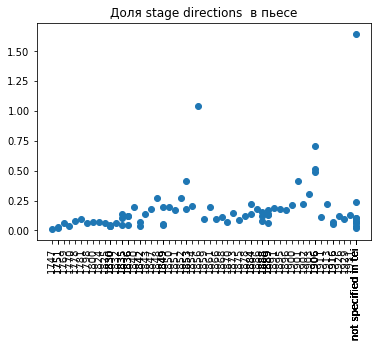

In [70]:
import matplotlib.pyplot as plt ## импортируем матплотлиб
written = raw_stages_data['written'] #дата написания -- в ось икс
stagestospeeches = raw_stages_data['stages_to_speeches_ratio'] #Доля stage directions относительно реплик
plt.title('Доля stage directions  в пьесе')
#plt.plot(written, stagestospeeches, '.') ## нарисуем скаттерплот
plt.scatter(written, stagestospeeches) # альт. версия с функцией scatter для скаттерплота 
plt.xticks(written, written, rotation='vertical') # чтобы подписи иксов были вертикальны
plt.show()

In [75]:
# уберем ребят без даты написания
stages_data = raw_stages_data.loc[raw_stages_data['written'] != 'not specified in tei']
#stages_data

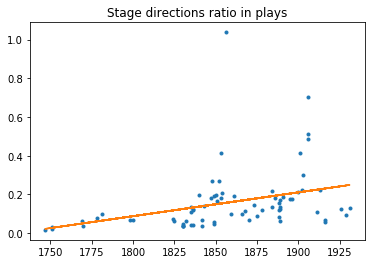

In [76]:
import numpy as np
plt.close() ## закрыть предыдущий
written = stages_data['written'] #дата написания -- в ось икс
stagestospeeches = stages_data['stages_to_speeches_ratio'] #Доля stage directions относительно реплик
x = pd.to_numeric(written)
y = pd.to_numeric(stagestospeeches)
plt.title('Stage directions ratio in plays') #('Доля stage directions в тексте')
plt.plot(x, y, '.')
## и теперь мы можем добавить в визуализацию линейную регрессию
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, '-')
plt.savefig('Stage directions ratio in plays.png')
plt.show()

In [77]:
# чтобы не копипастить код, засунем все в функцию, которая принимает два парметра
def my_plotter(xarr,yarr, label):
    x = pd.to_numeric(xarr)
    y = pd.to_numeric(yarr)
    plt.title(label)
    plt.plot(x, y, '.')
    ## добавить линейную регрессию
    m, b = np.polyfit(x, y, 1)
    plt.plot(x, m*x + b, '-')
    plt.savefig(label+'.png')
    plt.show()

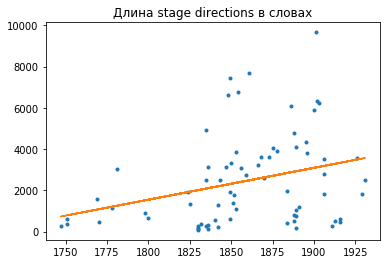

In [56]:
my_plotter (written, stages_data['len_stages_words'], 'Длина stage directions в словах') ## 'Длина stage directions в словах'

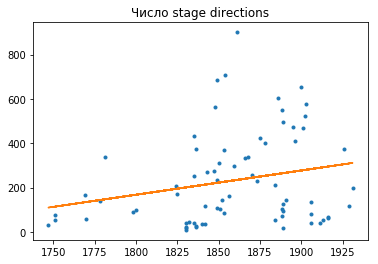

In [57]:
my_plotter (written, stages_data['number of stages'], 'Число stage directions')

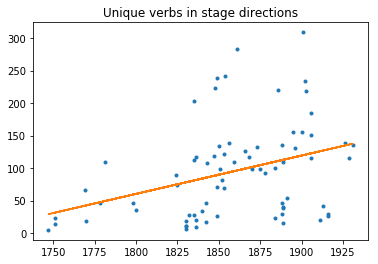

In [58]:
my_plotter (written, stages_data['number of unique verbs'], 'Unique verbs in stage directions') ##Уникальных глаголов в stage directions

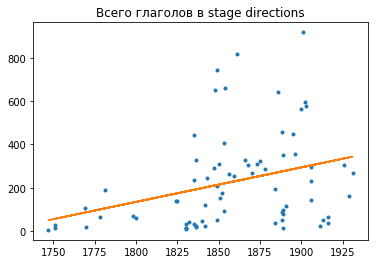

In [59]:
my_plotter (written, stages_data['total_number_of_verbs'], 'Всего глаголов в stage directions')

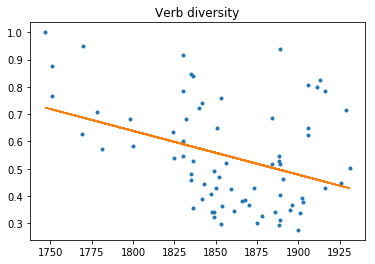

In [60]:
my_plotter (written, stages_data['verb_diversity(uniqueverbs/totalverbs)'], 'Verb diversity') 

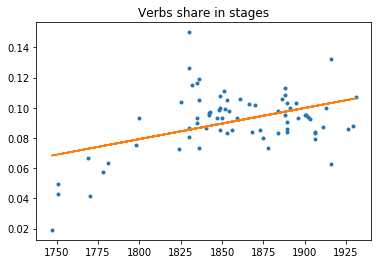

In [61]:
my_plotter (written, stages_data['verbs_share_in_stages'], 'Verbs share in stages') 

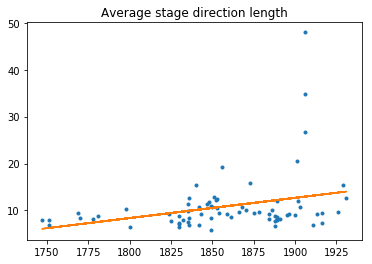

In [78]:
my_plotter (written, stages_data['av_stage_length'], 'Average stage direction length') 

In [96]:
stages_data.sort_values(by='stages_to_speeches_ratio', ascending=False)

,play name,written,print,number of stages,len_stages_words,len_speeches_words,total_number_of_verbs,verbs set,number of unique verbs,stages_to_speeches_ratio,verb_diversity(uniqueverbs/totalverbs),all_stage_texts
15,"Черепослов, сиречь Френолог",1856,1860,161,3088,2888,264,"знакомиться,съеживаться,всхлипывать,удерживать...",138,1.069252,0.522727,Сцена представляет учебный кабинет Шишкенгольм...
68,Балаганчик,1906,1906,38,1823,2658,144,"чертить,обнаруживаться,вытягиваться,откидывать...",116,0.685854,0.805556,Обыкновенная театральная комната с тремя стена...
32,Нахлебник,1848,1857,562,6641,11890,654,"вытягиваться,заикаться,растворяться,подумать,п...",223,0.558537,0.340979,Сцена представляет залу в доме богатого помещи...
11,Блонды,1853,1854,87,1089,2032,91,"всматриваться,подкатываться,замечать,мешать,вс...",69,0.535925,0.758242,"Княгиня, чрезвычайно богато одетая, выходит из..."
4,Незнакомка,1906,1907,80,2793,5260,232,"застывать,блестеть,грозить,опираться,проскальз...",151,0.530989,0.650862,Уличный кабачок. Подрагивает бело-матовый свет...
34,Дети Ванюшина,1901,not specified in tei,471,9661,18902,919,"вспоминать,мешать,обрадовать,наполняться,ожида...",309,0.511110,0.336235,Столовая в доме Ванюшина. Полутемная комната с...
13,Король на площади,1906,1907,133,3541,7366,297,"рассеиваться,всхлипывать,прибывать,прорываться...",185,0.480722,0.622896,Городская площадь. Задний план занят белым фас...
21,Вечер в Сорренте,1852,1888,144,1748,3766,175,"бросаться,противиться,оглядываться,вздыхать,от...",82,0.464153,0.468571,"(Театр представляет довольно большую комнату, ..."
23,Юбилей,1891,1892,144,1173,2675,117,"возвращаться,оглядываться,вздыхать,вставать,об...",54,0.438505,0.461538,"Кабинет председателя правления. Налево дверь, ..."
26,Свадьба Кречинского,1854,1856,709,6781,18022,662,"всхлипывать,удерживаться,попячиваться,вздыхать...",241,0.376262,0.364048,Утро. Гостиная в доме Муромских. Прямо против ...


In [97]:
stages_data.sort_values(by='number of unique verbs', ascending=False)

,play name,written,print,number of stages,len_stages_words,len_speeches_words,total_number_of_verbs,verbs set,number of unique verbs,stages_to_speeches_ratio,verb_diversity(uniqueverbs/totalverbs),all_stage_texts
34,Дети Ванюшина,1901,not specified in tei,471,9661,18902,919,"вспоминать,мешать,обрадовать,наполняться,ожида...",309,0.511110,0.336235,Столовая в доме Ванюшина. Полутемная комната с...
53,Дело,1861,1861,901,7704,23718,817,"покрутить,заикаться,вздыхать,предшествовать,по...",283,0.324817,0.346389,Квартира Муромских; гостиная. Три двери: одна ...
26,Свадьба Кречинского,1854,1856,709,6781,18022,662,"всхлипывать,удерживаться,попячиваться,вздыхать...",241,0.376262,0.364048,Утро. Гостиная в доме Муромских. Прямо против ...
1,Холостяк,1849,1849,687,7455,20961,743,"заикаться,всхлипывать,заваливаться,вздыхать,по...",239,0.355661,0.321669,"(Театр представляет гостиную не богатого, но и..."
29,На дне,1902,1903,525,6345,28273,596,"съеживаться,укладываться,вытягиваться,звякать,...",234,0.224419,0.392617,"Подвал, похожий на пещеру. Потолок – тяжелые, ..."
32,Нахлебник,1848,1857,562,6641,11890,654,"вытягиваться,заикаться,растворяться,подумать,п...",223,0.558537,0.340979,Сцена представляет залу в доме богатого помещи...
63,"Власть тьмы, или 'коготок увяз, всей птичке ...",1886,1887,604,6078,33553,644,"хмуриться,расслышать,удерживаться,вздыхать,вып...",220,0.181146,0.341615,Действие происходит осенью в большом селе. Сце...
35,Вишневый сад,1903,1904,575,6220,20787,576,"расслышать,удерживаться,отъезжать,вздыхать,уте...",218,0.299225,0.378472,"Комната, которая до сих пор называется детскою..."
16,Ревизор,1835,1836,433,4927,35830,442,"съеживаться,вытягиваться,заикаться,зажмуривать...",203,0.137510,0.459276,"Городничий, попечитель богоугодных заведений, ..."
13,Король на площади,1906,1907,133,3541,7366,297,"рассеиваться,всхлипывать,прибывать,прорываться...",185,0.480722,0.622896,Городская площадь. Задний план занят белым фас...
